# Lesson 4: Quantization Theory

In this lab, you will perform Linear Quantization.

#### Libraries to install
- If you are running this notebook on your local machine, you can install the following:

```Python
!pip install transformers==4.35.0
!pip install quanto==0.0.11
!pip install torch==2.1.1
```

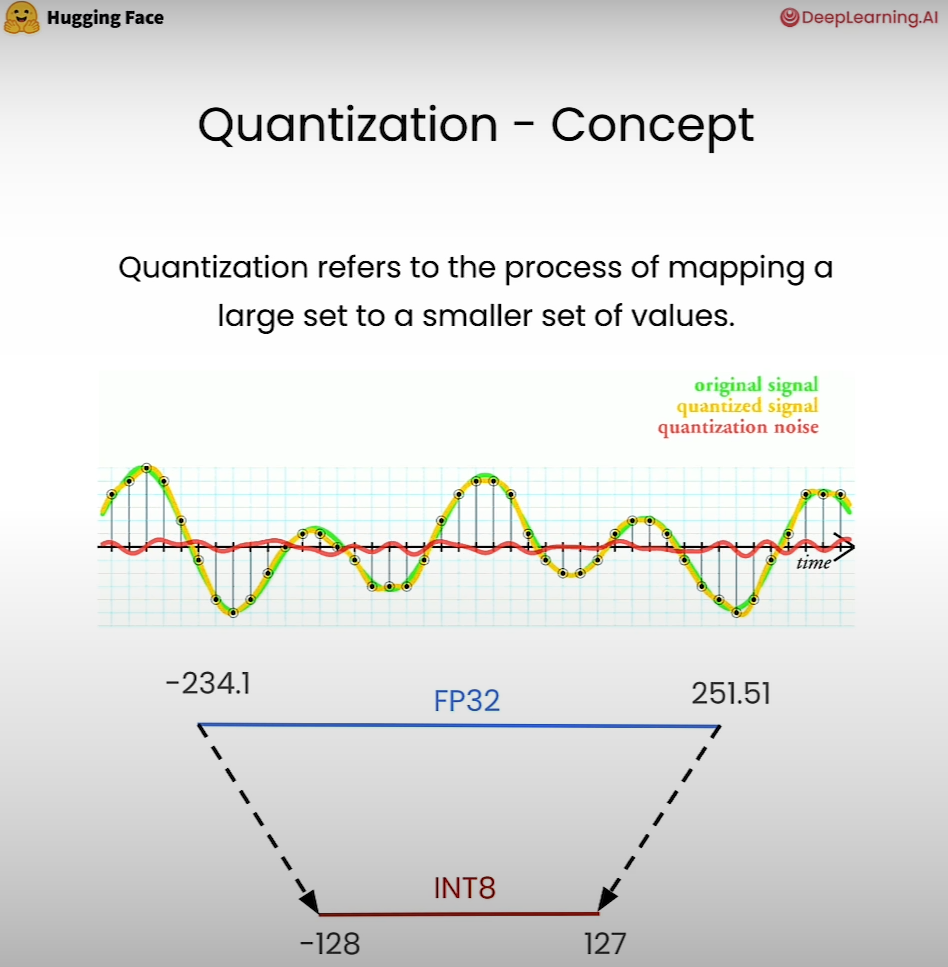

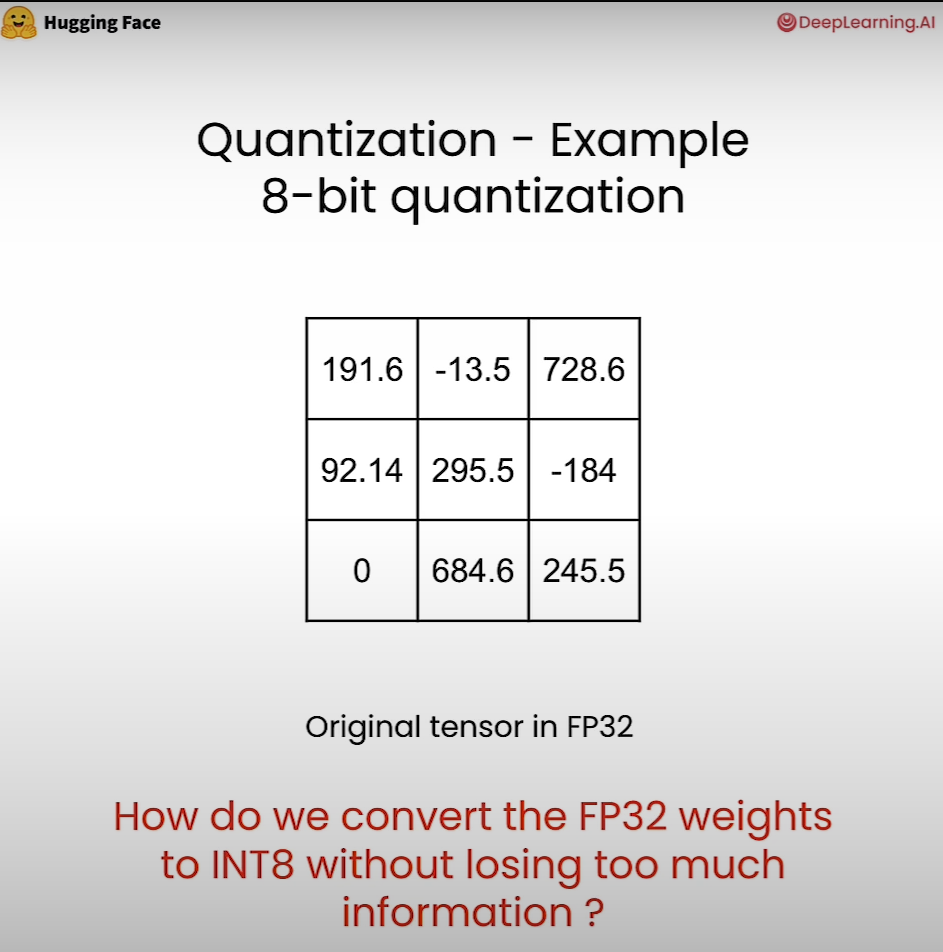

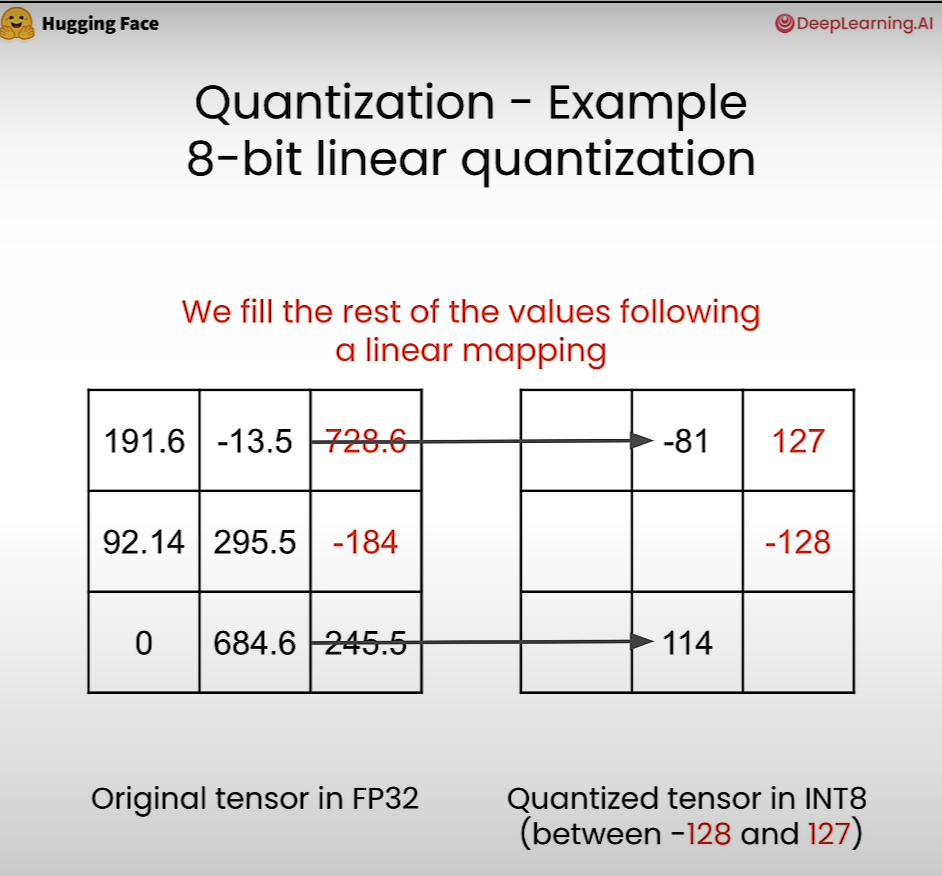

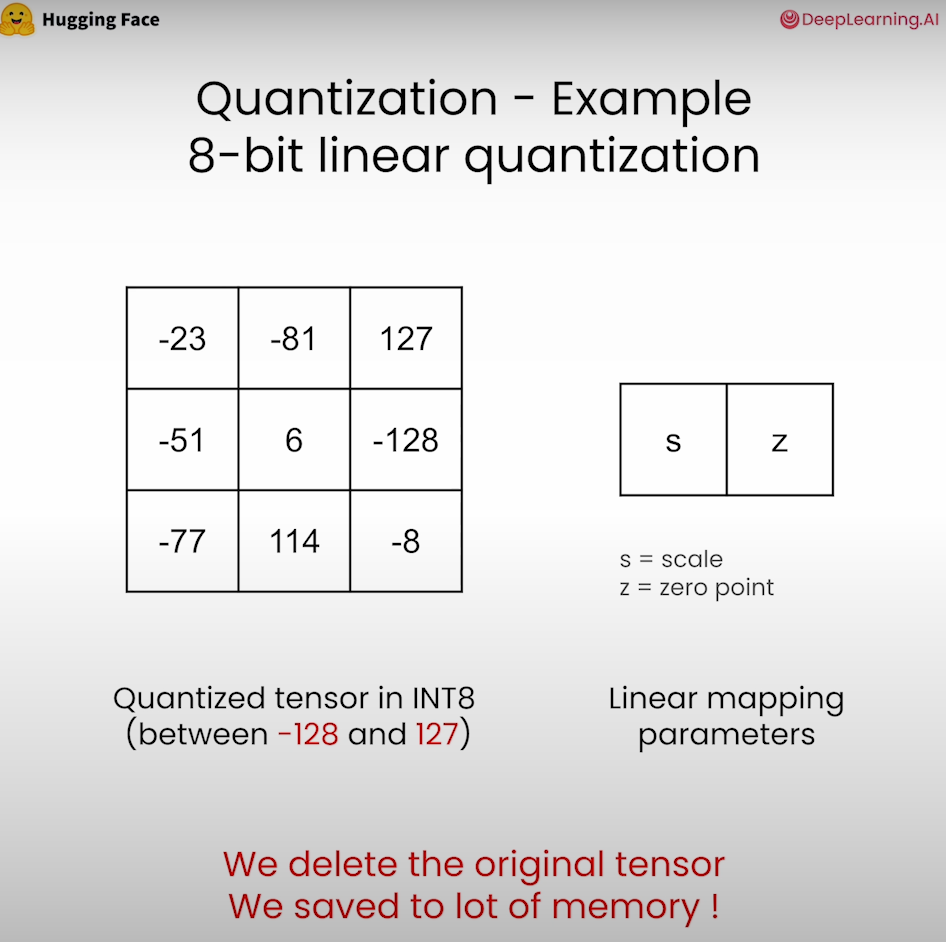

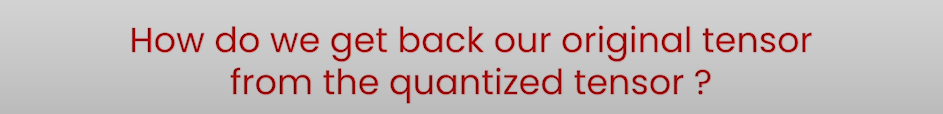

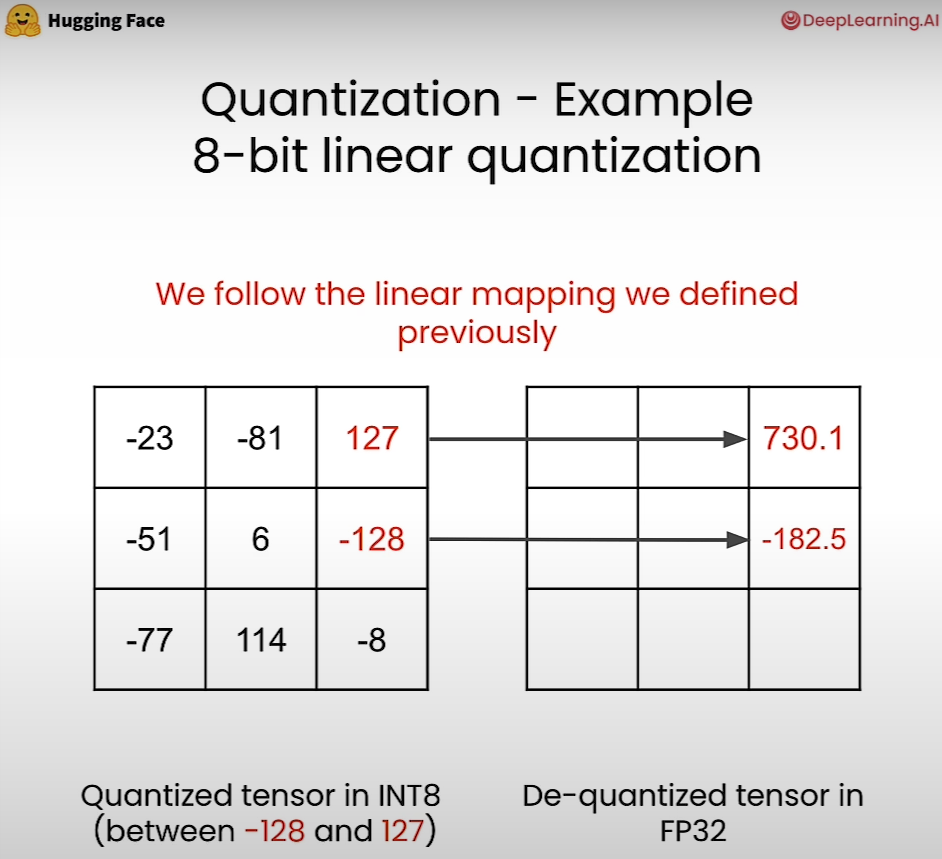

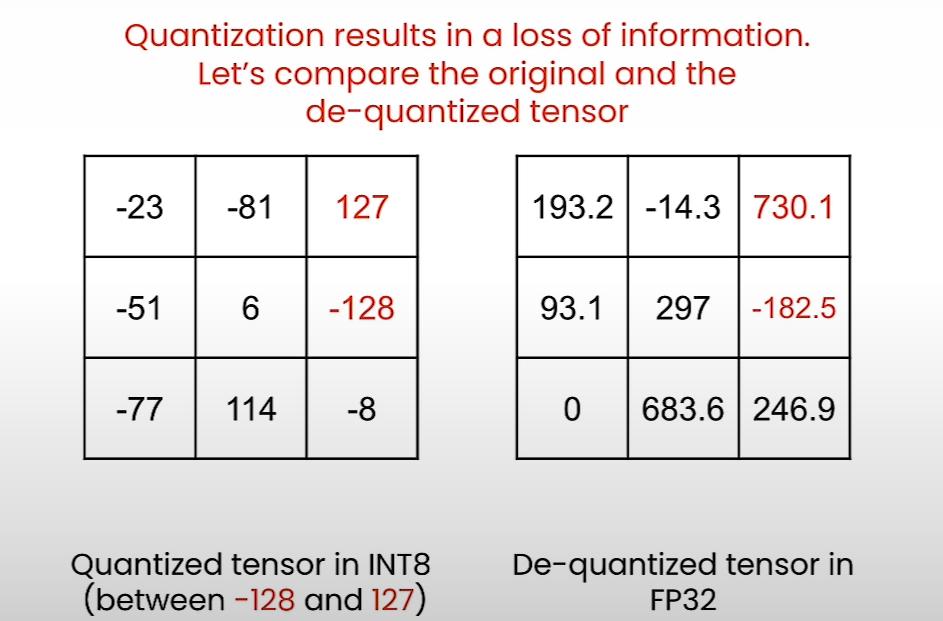

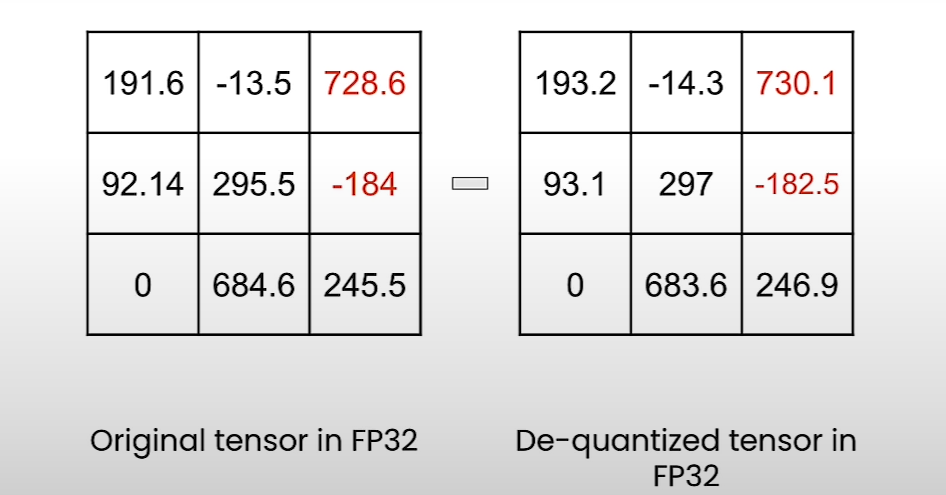

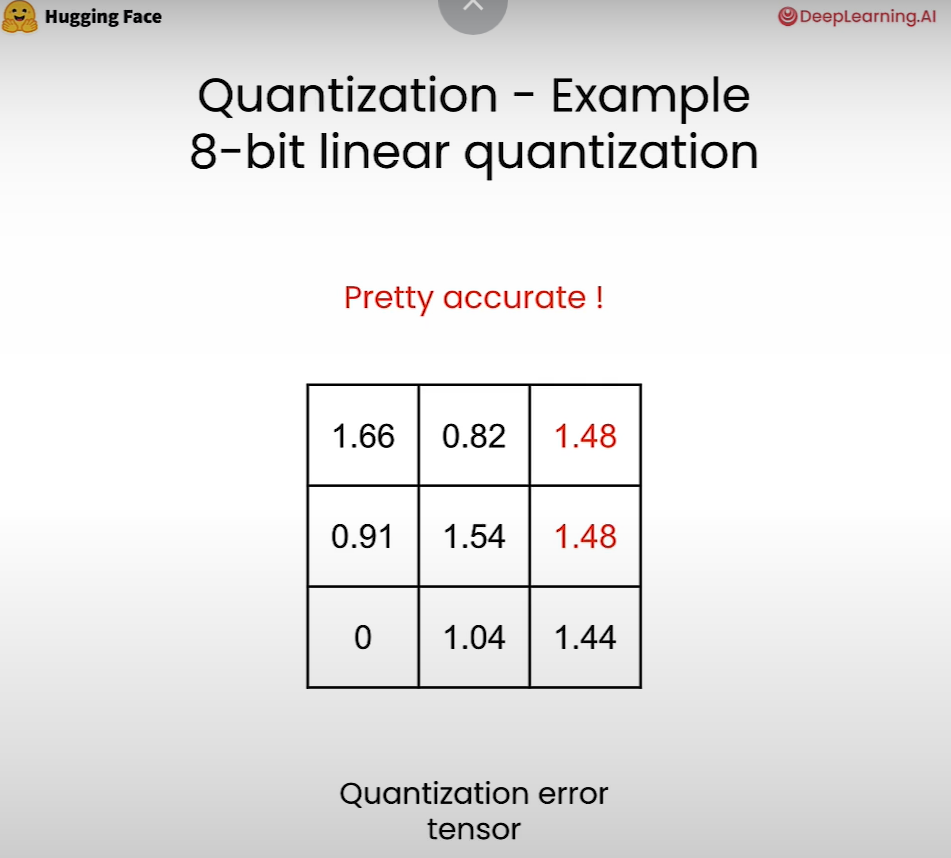

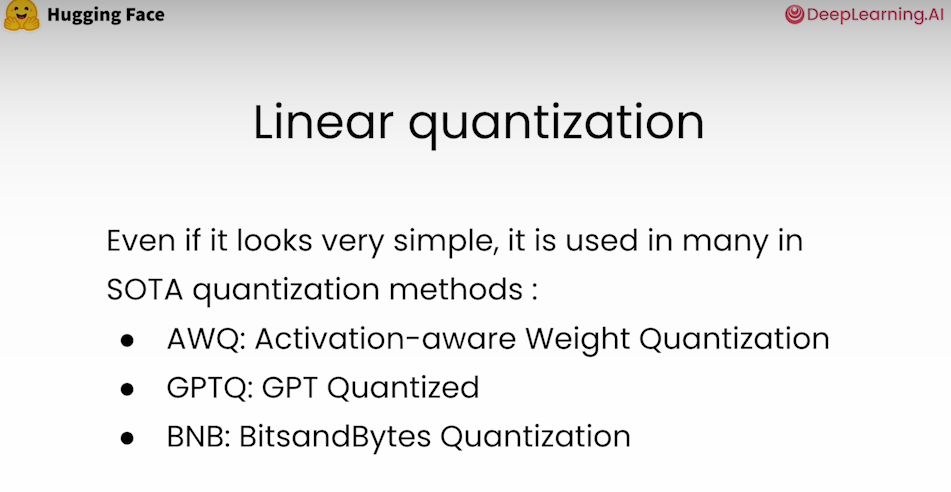

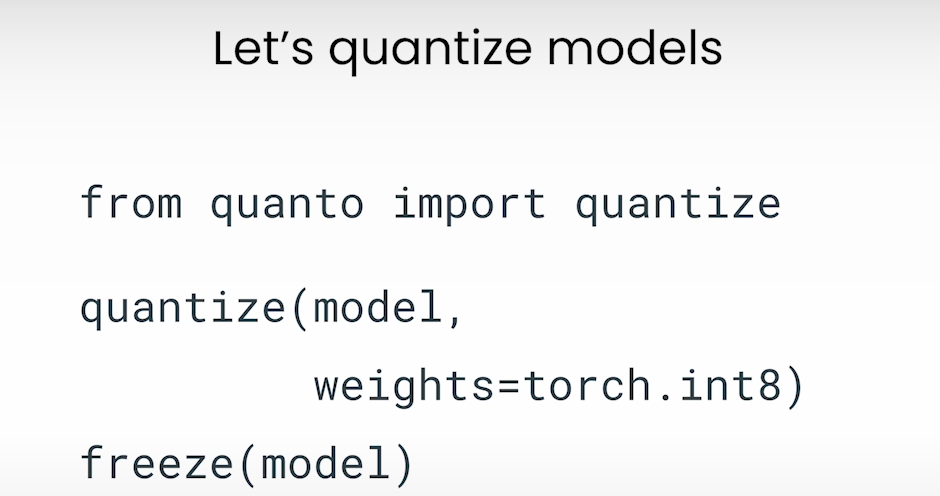

## T5-FLAN
- Please note that due to hardware memory constraints, and in order to offer this course for free to everyone, the code you'll run here is for the T5-FLAN model instead of the EleutherAI AI Pythia model.  
- Thank you for your understanding! 🤗

For the T5-FLAN model, here is one more library to install if you are running locally:
```Python
!pip install sentencepiece==0.2.0
```


### Without Quantization

In [ ]:
model_name = "google/flan-t5-small"

In [ ]:
import sentencepiece as spm
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-small")

In [ ]:
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-small")

In [ ]:
input_text = "Hello, my name is "
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0]))

In [ ]:
from helper import compute_module_sizes
module_sizes = compute_module_sizes(model)
print(f"The model size is {module_sizes[''] * 1e-9} GB")

In [ ]:
#v2 -> code as in video
from transformers import AutoModelForCausalLM,AutoTokenizer
model_name = "EleutherAI/pythia-410m"
model = AutoModelForCausalLM.from_pretrained(model_name,low_cpu_mem_usage=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
text = "Hello, my name is "
inputs = tokenizer(text, return_tensors="pt").input_ids
outputs = model.generate(**inputs,max_new_tokens=10)
outputs

In [ ]:
print(tokenizer.decode(outputs[0],skip_special_tokens=True))

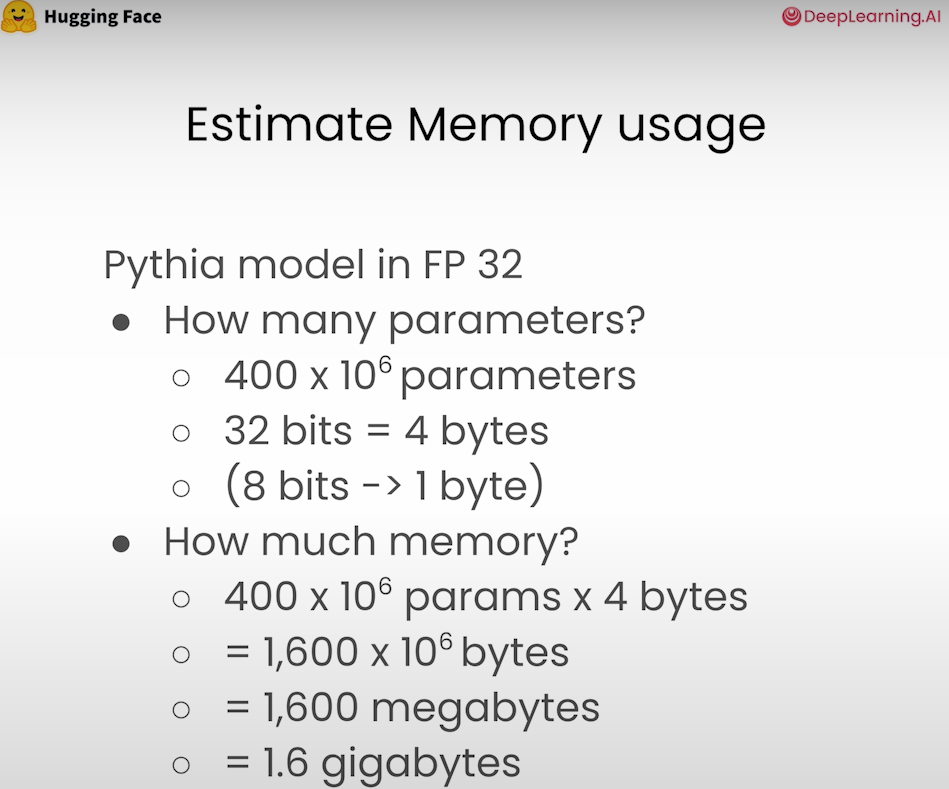

In [ ]:
from helper import compute_modules_sizes

In [ ]:
module_sizes = compute_modules_sizes(model)

In [ ]:
print(f"the model size is {module_sizes['']*1e-9} GB")

## Quantize the model (8-bit precision)

In [ ]:
from quanto import quantize, freeze
import torch

In [ ]:
quantize(model, weights=torch.int8, activations=None) # what does mean by activations=none?

In [ ]:
print(model)

In [ ]:
#v2
print(model.gpt_neox)

In [ ]:
print(model.gpt_neox.layers[0].attention.dense.weight)

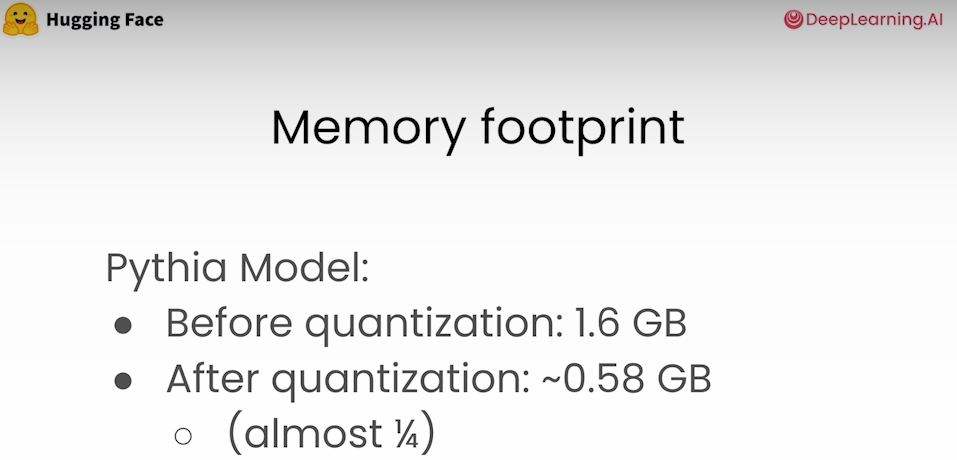

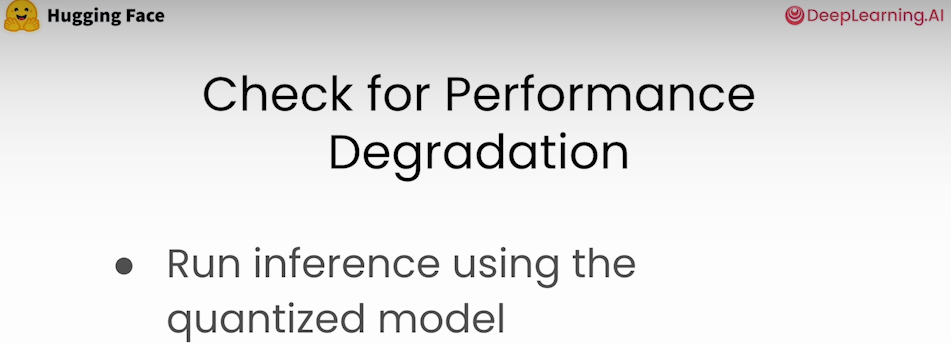

### Freeze the model
- This step takes a bit of memory, and so for the Pythia model that is shown in the lecture video, it will not run in the classroom.
- This will work fine with the smaller T5-Flan model.

In [ ]:
freeze(model)

In [ ]:
module_sizes = compute_module_sizes(model)
print(f"The model size is {module_sizes[''] * 1e-9} GB")

### Try running inference on the quantized model

In [ ]:
input_text = "Hello, my name is "
input_ids = tokenizer(input_text, return_tensors="pt").input_ids

outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0]))

In [ ]:
#v2
outputs = model.generate(**inputs,max_new_tokens=10)
outputs

In [ ]:
print(tokenizer.decode(outputs[0],skip_special_tokens=0))

## Note: Quantizing the model used in the lecture video will not work due to classroom hardware limitations.
- Here is the code that Marc, the instructor is walking through.  
- It will likely run on your local computer if you have 8GB of memory, which is usually the minimum for personal computers.
  - To run locally, you can download the notebook and the helper.py file by clicking on the "Jupyter icon" at the top of the notebook and navigating the file directory of this classroom.  Also download the requirements.txt to install all the required libraries.

### Without Quantization



- Load [EleutherAI/pythia-410m](https://huggingface.co/EleutherAI/pythia-410m) model and tokenizer.

```Python
from transformers import AutoModelForCausalLM
model_name = "EleutherAI/pythia-410m"

model = AutoModelForCausalLM.from_pretrained(model_name,
                                             low_cpu_mem_usage=True)
print(model.gpt_neox)


from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

- Write a start of a (`text`) sentence which you'd like the model to complete.
```Python
text = "Hello my name is"
inputs = tokenizer(text, return_tensors="pt")
outputs = model.generate(**inputs, max_new_tokens=10)
outputs
print(tokenizer.decode(outputs[0], skip_special_tokens=True))
```

- Compute the model's size using the helper function, `compute_module_sizes`.
```Python
from helper import compute_module_sizes
module_sizes = compute_module_sizes(model)
print(f"The model size is {module_sizes[''] * 1e-9} GB")
print(model.gpt_neox.layers[0].attention.dense.weight)
```
**Note:** The weights are in `fp32`.

### 8-bit Quantization

```Python
from quanto import quantize, freeze
import torch

quantize(model, weights=torch.int8, activations=None)
# after performing quantization
print(model.gpt_neox)
print(model.gpt_neox.layers[0].attention.dense.weight)
```

- The "freeze" function requires more memory than is available in this classroom.
- This code will run on a machine that has 8GB of memory, and so it will likely work if you run this code on your local machine.

```Python
# freeze the model
freeze(model)
print(model.gpt_neox.layers[0].attention.dense.weight)

# get model size after quantization
module_sizes = compute_module_sizes(model)
print(f"The model size is {module_sizes[''] * 1e-9} GB")

# run inference after quantizing the model
outputs = model.generate(**inputs, max_new_tokens=10)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))
```

#### Comparing "linear quantization" to "downcasting"

To recap the difference between the "linear quantization" method in this lesson with the "downcasting" method in the previous lesson:

- When downcasting a model, you convert the model's parameters to a more compact data type (bfloat16).  During inference, the model performs its calculations in this data type, and its activations are in this data type.  Downcasting may work with the bfloat16 data type, but the model performance will likely degrade with any smaller data type, and won't work if you convert to an integer data type (like the int8 in this lesson).


- In this lesson, you used another quantization method, "linear quantization", which enables the quantized model to maintain performance much closer to the original model by converting from the compressed data type back to the original FP32 data type during inference. So when the model makes a prediction, it is performing the matrix multiplications in FP32, and the activations are in FP32.  This enables you to quantize the model in data types smaller than bfloat16, such as int8, in this example.

#### This is just the beginning...
- This course is intended to be a beginner-friendly introduction to the field of quantization. 🐣
- If you'd like to learn more about quantization, please stay tuned for another Hugging Face short course that goes into more depth on this topic (launching in a few weeks!) 🤗

## Did you like this course?

- If you liked this course, could you consider giving a rating and share what you liked? 💕
- If you did not like this course, could you also please share what you think could have made it better? 🙏

#### A note about the "Course Review" page.
The rating options are from 0 to 10.
- A score of 9 or 10 means you like the course.🤗
- A score of 7 or 8 means you feel neutral about the course (neither like nor dislike).🙄
- A score of 0,1,2,3,4,5 or 6 all mean that you do not like the course. 😭
  - Whether you give a 0 or a 6, these are all defined as "detractors" according to the standard measurement called "Net Promoter Score". 🧐

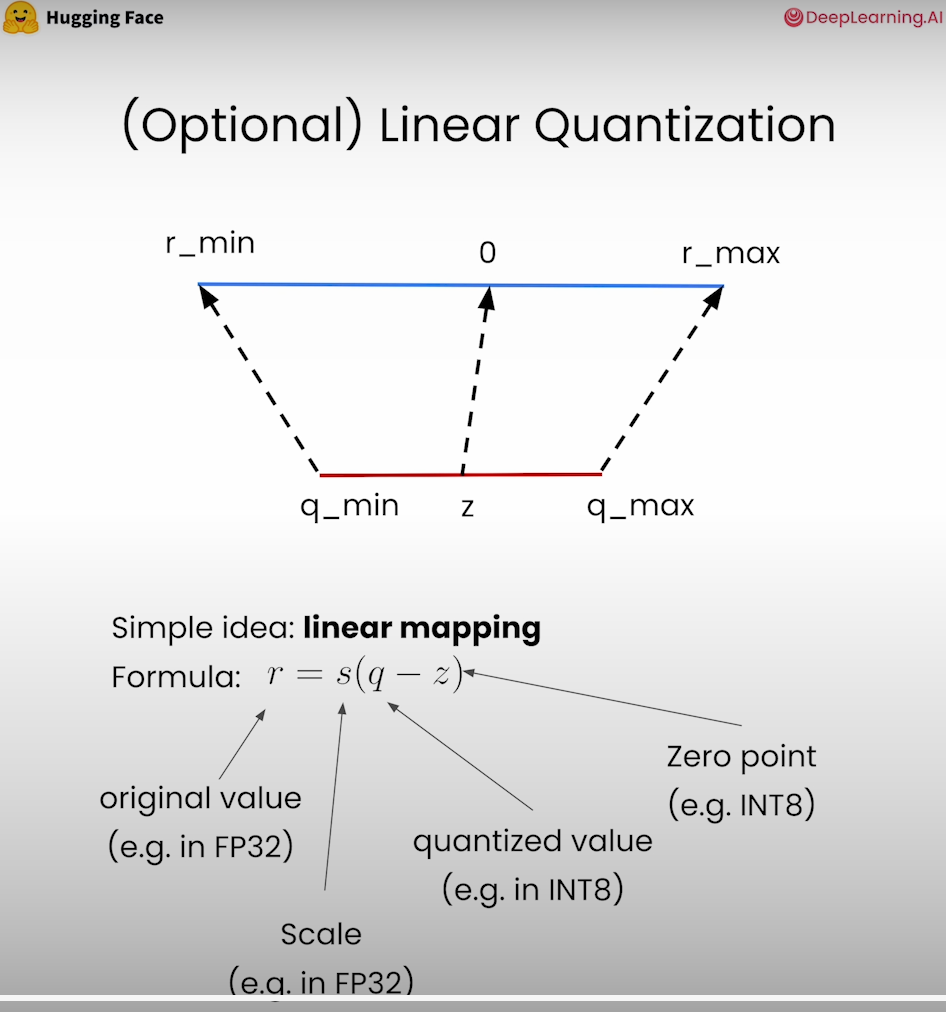

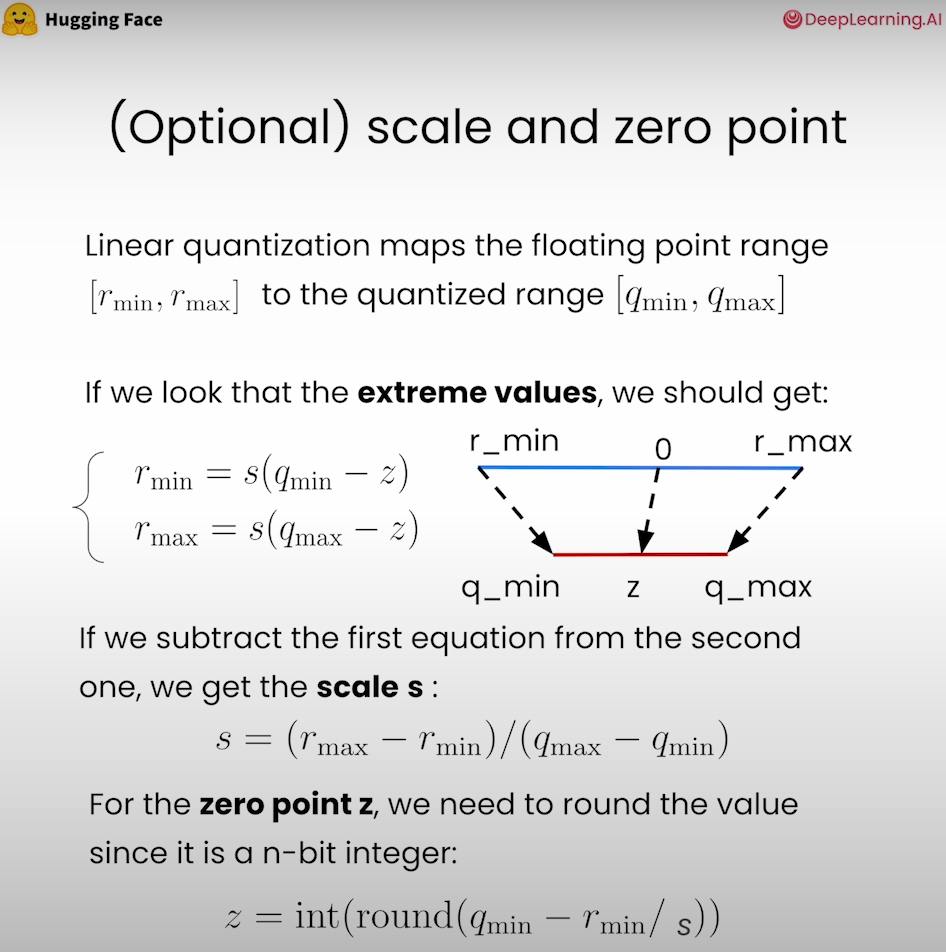

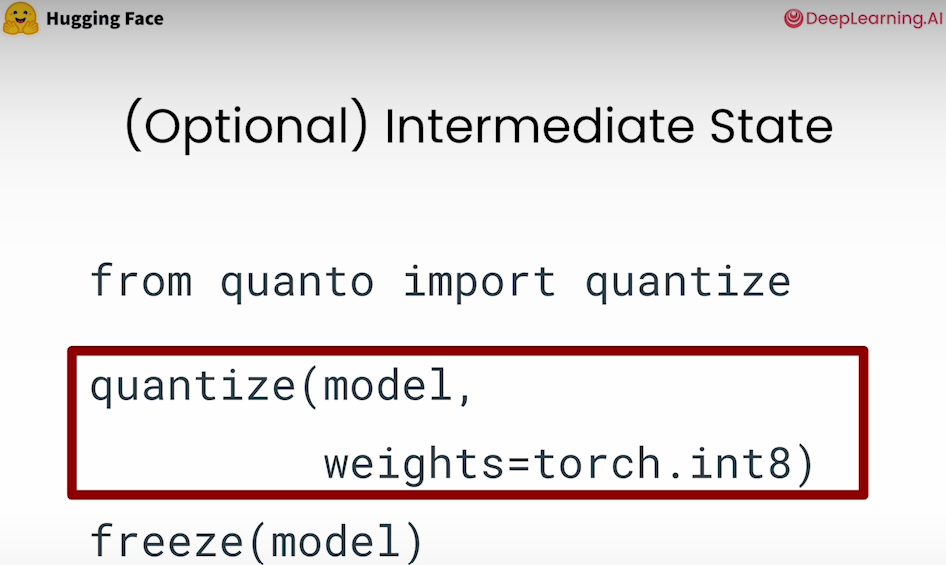

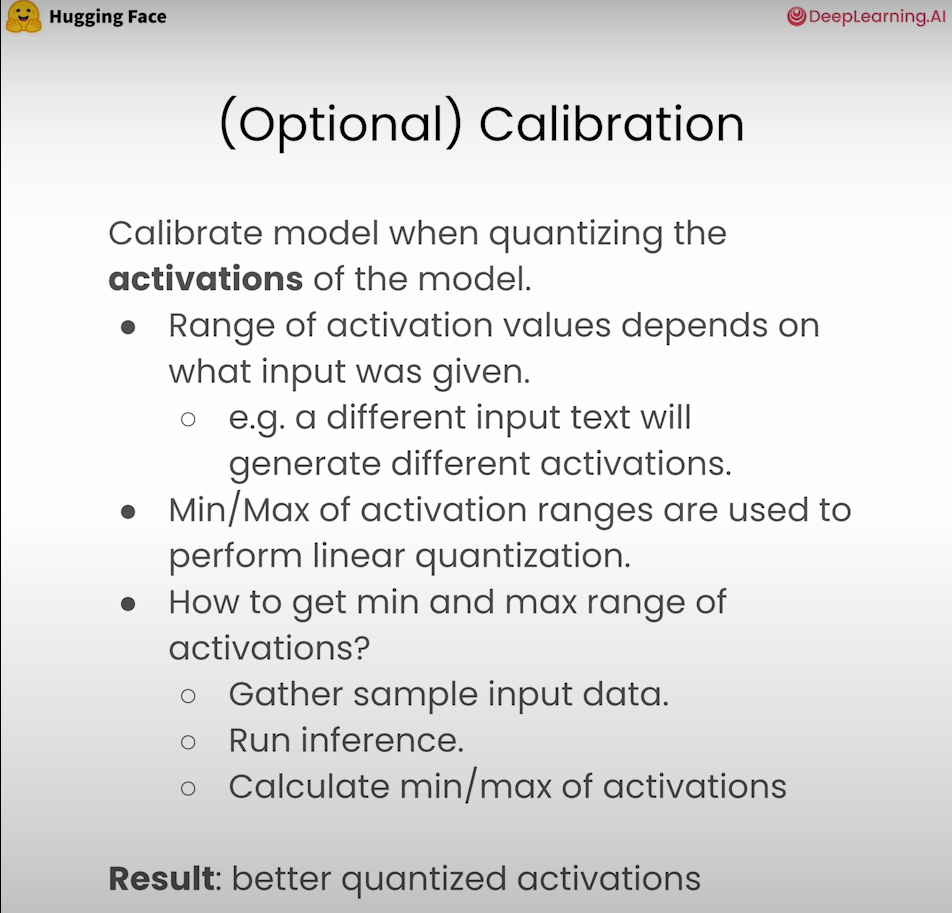

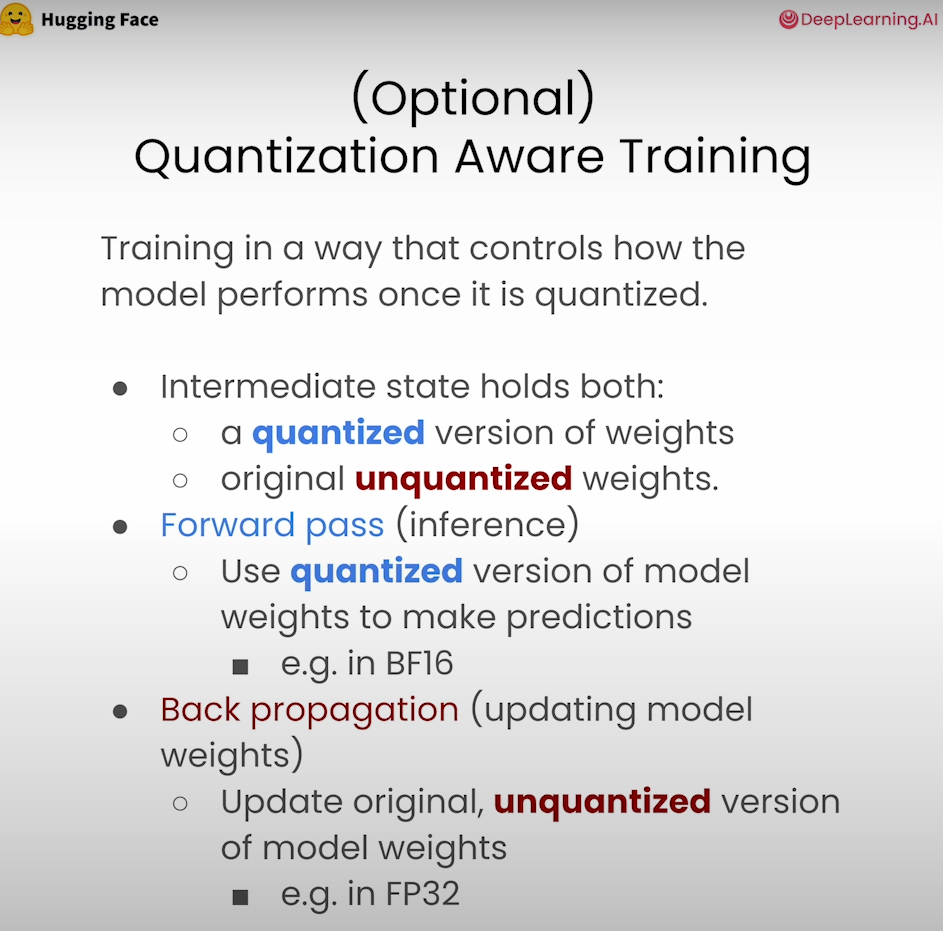